<a href="https://colab.research.google.com/github/Nozasp/PredictiveCoding/blob/main/PC_main_Pytoch_derivative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install / Import

In [ ]:
import sys


import os, sys
from google.colab import drive
#drive.mount('/content/gdrive')
#nb_path = '/content/gdrive/MyDrive/Github/PredictiveCoding/Lib/site-packages'
#os.symlink('/content/gdrive/MyDrive/Github/PredictiveCoding/main/src', nb_path)
#sys.path.insert(0, nb_path)  # or append(nb_path)

#path_to_module = '/content/gdrive/MyDrive/ColabNotebooks/PC_param.ipynb'
#sys.path.append(path_to_module)

In [ ]:
!pip install import_ipynb
#!pip install --target=$/content/gdrive/MyDrive/Github/PredictiveCoding/Lib/site-packages import_ipynb


In [ ]:
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F #F.mse_loss
import scipy
import scipy.ndimage as nd


from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
#from scipy.sparse import identity

from google.colab import drive
drive.mount('/content/gdrive')
import sys

path_to_module = "/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src/PC_param.ipynb"
sys.path.append(path_to_module)
%cd /content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
!pwd

!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
PC_filters.ipynb    PC_Main_toPytorch.ipynb	PC_StimuliSequence.ipynb
PC_functions.ipynb  PC_param.ipynb
PC_Main.ipynb	    PC_Step_8_loopJeiJii.ipynb


# Function

In [ ]:
# 2- Input/Output function
def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))#, param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
      plt.xlim(xlim_ar) #[0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()

def plot_s(range_sim, S_e, S_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei)) #, param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)
    if xlim_ar != None:
      plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    #plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()

# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()

In [ ]:

# Filters gauss and Dog and LoG

def gaussian_filter(s, N):
    k = np.arange(1, N+1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
    gaussW2 = gaussW / (.009**2 / np.max(gaussW)) #1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N+1)
    gaussIn =  np.exp(-(k - k[:, np.newaxis])**2 / (2 * sIn**2))
    gaussOut = np.exp(-(k - k[:, np.newaxis])**2 / (2 * sOut**2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None :
        print('zero max')
        dog = 0
    else:
      dog = dog/ (.042**2 / np.max(dog)) #.0088
    return dog

def LoG_filter(s, N):
  x_lap = np.eye(N)
  lapl_filter = nd.gaussian_laplace(x_lap , sigma= (s, s))
  return lapl_filter


def dLogGaus(s =.61, N=20):
  dig = LoG_filter(s, N) + gaussian_filter(.019 *s, N)
  return dig

# Class

In [ ]:
# ***************** CLASS ***************************************
from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network
pars = default_parameters_network()

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise, Jee = pars['be'], pars['hme'], pars['I_noise'], pars['Jee']
    taui, ai, bi, hmi, Jii, Jei, Jie = pars['taui'], pars['ai'], pars['bi'], pars['hmi'], pars['Jii'], pars['Jei'], \
                                       pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq = pars['Jiq']  #0.85; #nA
    Jin = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma = pars['gamma']  # nmda coupling parameter from brunel
    # I1, I2 = pars['I1'], pars['I2']
    c_dash = pars['c_dash']
    sigma = pars['sigma']  #param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)

    sigmaIn = pars['sigmaIn']

    #Input parameters
    In0 = pars['In0']       #% Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']   #% Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']       #% Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']   #% Max firing rate of feedback populations (Hz)

    #Gaussian filter
    #sIn = pars['sigmaInh'][0]
    #sOut = pars['sigmaInh'][1]

    def __init__(self,sEI, sIn, sOut, N): # sEI=4, sIn=.2, sOut=1.2,
      # Weights (from gaussian filter)
      self.N = N  #pars['NumN']
      self.wei = torch.tensor(dog_filter(sOut, int(N)).astype(float))#fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
      self.wii = torch.tensor(np.eye(int(N)).astype(float))#dog_filter(sIn, sOut, N)#np.eye(N) #
      self.wie = torch.tensor(gaussian_filter(sEI, int(N)).astype(float)) #dog_filter(sIn, sOut, N)
      self.wes = torch.tensor(np.eye(int(N)).astype(float)) # Identity matrix
      self.f = np.arange(1, N +1)
      self.sEI = sEI
      self.sIn = sIn
      self.sOut = sOut


    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())




# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size


    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°
class Neurons:
    def __init__(neur, Ltime, Ntime , RFfrequency =0, init_r=0, init_S=0 ):
        neur.r = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'))
        neur.drdt = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'))
        neur.S = torch.tensor(np.zeros((Ltime,Ntime), dtype='float64'))
        neur.Itot = (np.zeros((Ltime, Ntime), dtype='float64'))
        neur.Phi = (np.zeros((Ltime, Ntime))) #np.zeros(Ltime)
        neur.rinit = init_r
        neur.Sinit = init_S
        neur.RFf = RFfrequency
        if neur.Sinit != 0:
          neur.S[0,:] = neur.Sinit
         # neur.S = np.full((Ltime, Ntime), neur.Sinit)



    def printNeur(neur):
        print("size S and r andItot and Phi is: ", neur.S.shape, neur.r.shape, neur.Itot.shape, neur.Phi.shape)



class Stim:
  def __init__(self, param, simu, f=[10], ISI = 1, dur = 0.2): #8
    self.f = f #array of frequency stimulus types
    self.ISI = ISI # inter-stimulus interval
    self.dur = dur #duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
    self.tail   = 0;
    self.predDt = 0;
    self.pred   = 0;
    self.InMax = param.InMax
    self.In0 = param.In0

    # Instantaneous frequency
    f_instant = np.zeros((int(self.ISI / simu.dt)+1, 1)) #size ISI : 1 /dt : 1000

    #print(f.shape)
    for fx in self.f:
      fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx, #just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                               np.zeros((int(self.ISI / simu.dt), 1))))   # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    f_stim = np.vstack((f_instant, fx_array)) #stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
    self.f_stim = f_stim[1:] #1400*1

  #bottom up sensory Input # duration 1sec
  def sensoryInput(self, parameter, simu,sigmaIn = None, paramf = None , f_stim = None, InMax = None, In0 = None):
      #paramf = np.arange(1, 101)
      w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

      #totalAct = w.sum(axis = 1) #sum over each row
      #norm_w = (w.T / totalAct).T # elementwise division
      In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0), 0) #if stim >0 give InMax * weight + In0 otherwise give 0
      if self.tail != 0:
        tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
        In = np.hstack((In, tail_zeros))

      range_sim = np.arange(1, In.shape[0] +1)
      self.In = In
      self.w = w
      self.sigmaIn = sigmaIn

      return In, range_sim, w, sigmaIn


  def printStim(self):
    print("frequence of stimulus f:", self.f, "  ISI:",self.ISI, " Size In:", self.In.shape, "Size w:", self.w.shape, "  f_stim:", self.f_stim.shape,
          "sigmaIn:", self.sigmaIn)



In [ ]:

class MyModel(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel, self).__init__()
        torch.manual_seed(2020)
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)

        # Define a trainable parameter not sure about what i m doing
        #self.weight = nn.Parameter(torch.rand(self.N), requires_grad=True)
        self.weight = nn.Parameter(torch.rand(5, requires_grad = True))
        #(data@weights) + bias
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True))


        # Define other model parameters, layers, or components here if needed

    def phi(self, I_tot, a, b, hm):
        return hm * (1 / (1 + np.exp(- (a * I_tot + b))))


    def forward(self, stim):
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0]),(self.N)) #, requires_grad=True)
        r_i = torch.zeros(In.shape[0], self.N) #, requires_grad=True)
        #r_i = torch.zeros((In.shape[0], (self.N)))
        s_ampa = torch.zeros((In.shape[0], (self.N)))
        s_gaba = torch.zeros((In.shape[0], (self.N)))
        i_tot_e = torch.zeros((In.shape[0], (self.N)))
        i_tot_i = torch.zeros((In.shape[0], (self.N)))
        dr_e_dt = torch.zeros((In.shape[0], (self.N)))
        dr_i_dt = torch.zeros((In.shape[0], (self.N)))

        # Perform integration over time steps
        for k in range(1, In.shape[0]):
            i_tot_e[k, :] = float(self.Jee) * torch.FloatTensor(s_ampa[k - 1, :]) - float(self.Jie) * torch.FloatTensor(torch.matmul(s_gaba[k - 1, :].float(), (self.param.wie).float())) + float(self.Jin) * In[k-1,:] #(torch.tensor(In[k-1,:], requires_grad = True).float()
            i_tot_i[k, :] = self.Jei * torch.matmul(s_ampa[k - 1, :], (self.param.wei).float()) - self.Jii * torch.matmul(s_gaba[k - 1, :].float(), (self.param.wii).float())

            phi_arr_e = self.phi(i_tot_e[k, :].detach().numpy(), self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :].detach().numpy(), self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
            dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        return r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt

# Initiate classes

In [ ]:
N=20
param = Parameter(N = 20, sIn = .1, sOut =3., sEI = .2)

#J =[Jin, Jee, Jie, Jei, Jii]
sigmas = [param.sOut, param.sEI]# = sigmas
#param.Jin, param.Jee, param.Jie, param.Jei, param.Jii = J

print("sIN", sigmas[0]/30, "sout", sigmas[0], "sEI", sigmas[1])
#print("sIN", sigmas[0], "sout", sigmas[1], "sEI", sigmas[2])
print("Jee:", param.Jee, "  Jei:", param.Jei)
print("Jii", param.Jii, "Jie:", param.Jie, " Jin:", param.Jin)

J = param.Jin, param.Jee, param.Jie, param.Jei, param.Jii
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4) #dt #rangeSim #dur = 2s
simu.printSim()

# \\\\\\\\\\\ Bottom up sensory input
stim = Stim(param,simu, dur=.3, ISI=.05) #dur = 1s Isi=1s
#print(param.f.shape)
In, range_sim, w, sigmaIn =stim.sensoryInput(param, simu, sigmaIn = 2.)
#stim.printStim()

# \\\\\\\\\\\ Neurons (empty variables)
pop3 = Neurons(In.shape[0], param.N)#
pop4 = Neurons(In.shape[0], param.N)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 # for i in range(1, In.shape[0]):
#      r_E, r_I, S_ampa, S_gaba, I_tot_E, I_tot_I, In = wilsonCowanWong(pop3, pop4, simu, param, i, stim)



sIN 0.1 sout 3.0 sEI 0.2
Jee: 0.2   Jei: 1.4
Jii 6.7 Jie: 0.2  Jin: 0.008
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


In [ ]:
type(torch.tensor(stim.In)) == torch.Tensor


True

In [ ]:
weight = (torch.rand(param.N).requires_grad_().float())
In = torch.tensor(stim.In, requires_grad = True).float()
In@weight

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<MvBackward0>)

# 1) call my model

0.072


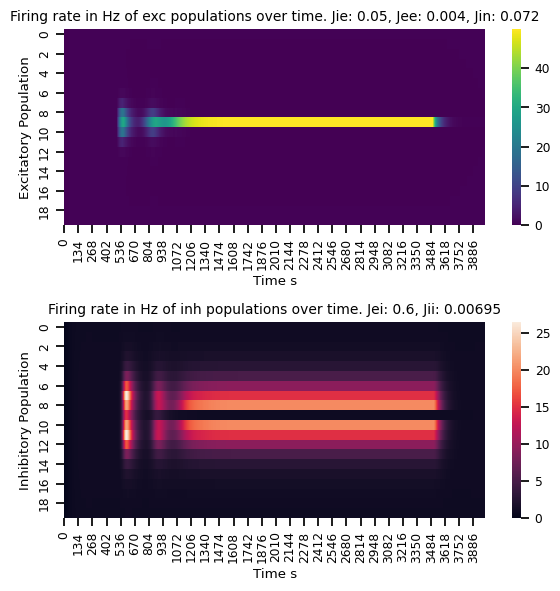

In [ ]:
J = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
mymodel = MyModel(param, simu, **J)
mymodel.Jdic = J
print(mymodel.Jdic['Jee'])
#print(stim.In)

In = stim.In
sti = torch.tensor(In).float() #torch.tensor(In, requires_grad = True).float()

r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt = mymodel.forward(stim = sti)


HeatMap(r_e, r_i, J)

In [ ]:
#plt.plot(torch.arange(In.shape[0]), dr_e_dt[:,9])
#plt.plot(torch.arange(In.shape[0]), r_e[:,9])

# 2) The loss function

### Convertion from firing rate (Hertz) to probability [0,1]

Then when I get the mse, I don t have to forget that I need time before the input where there is 8. [00000111111111111111100000]

should sum to 1: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
should sum to 1: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


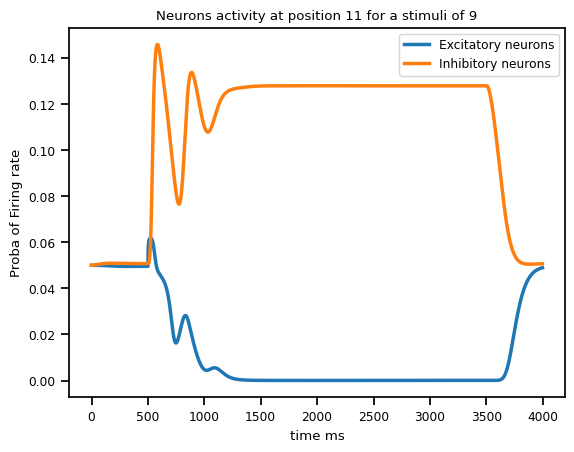

In [ ]:
# make it proba

def make_it_proba(r_e):
  prob_r = torch.zeros((r_e.shape[0], r_e.shape[1])) #empty matrix initialisation
  sum_r_e = torch.sum(r_e, 1)
  torch.div(r_e, sum_r_e.resize_(r_e.shape[0],1), out = prob_r)#torch.transpose(r_e, dim0=0 ,dim1=1)
  prob_r[prob_r != prob_r] = 0.05 #to replace nan to 1/20 - to sum to 1
  print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

  return prob_r.resize_(r_e.shape[0],20)

plt.plot(np.arange(0, r_e.shape[0]), make_it_proba(r_e)[:,11], label = "Excitatory neurons")
plt.plot(np.arange(0, r_i.shape[0]), make_it_proba(r_i)[:,11], label = "Inhibitory neurons")
plt.title("Neurons activity at position 11 for a stimuli of 9")
plt.xlabel("time ms")
plt.ylabel("Proba of Firing rate")
plt.legend()

### check that the mse works

In [ ]:
expected_prob_stim = torch.ones((r_e.shape[0]))
r_prob = make_it_proba(r_e)

# Compute the mean squared error
mse = F.mse_loss(r_prob[:,9], expected_prob_stim)
print("Mean Squared Error:", mse.item())

should sum to 1: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
Mean Squared Error: 0.2125728875398636


### Custom Loss function

In [ ]:

# Compute the mean squared error

def custom_loss(dr_dt, r ,N, target_population, target_derivative=0, ISI = 500):
  # Define your expected firing rate probability for each population
  prob_r = make_it_proba(r)
  expected_prob_stim = torch.cat((torch.zeros(ISI), torch.ones((r.shape[0])- ISI*2),torch.zeros(ISI)), 0)#, 1))
  #plt.plot(torch.arange(0, stim.shape[0]), stim) to check sequence of stim
  expected_prob_nostim = torch.zeros((r.shape[0]))# ,1)) #r.shape[1]))
  #print("expected_prob_stim.shape:", expected_prob_stim.shape)
  loss_mse_nostim = torch.zeros(N)

  dr_dt_penalty_stim = torch.zeros(1)
  dr_dt_penalty_nostim = torch.zeros(N)
  dr_dt_target_penalty = torch.zeros(N)
  for i in range(1, N):
    #want to penalise the small values for dredt at 9
    if i == stim.f[0]:
      dr_dt_penalty_stim = torch.mean(torch.relu(- dr_dt[:,i])**2)  # Penalize negative derivatives
      if target_derivative != 0: dr_dt_target_penalty = torch.mean((dr_dt - target_derivative)**2)  # Approach target derivative
      loss_mse_stim = F.mse_loss(prob_r[:,i], expected_prob_stim) #mse torch.mean((prob_r[:,i] - expected_prob_stim)**2)
    #want to penalise big values for drdt different of 9
    elif i != stim.f:
      dr_dt_penalty_nostim[i] = torch.mean(torch.relu(dr_dt[:,i])**2)  # Penalize positive derivatives
      if target_derivative != 0: dr_dt_target_penalty = torch.mean((dr_dt - target_derivative)**2)  # Approach target derivative
      loss_mse_nostim[i] = F.mse_loss(prob_r[:,i],expected_prob_nostim)# - expected_prob_nostim)**2)

  if target_population == 'stim.f':
    dr_dt_penalty_tot = torch.mean(dr_dt_penalty_stim + (dr_dt_target_penalty)+ loss_mse_stim)
  elif target_population == None:
    dr_dt_penalty_tot = torch.mean(dr_dt_penalty_nostim + dr_dt_target_penalty+ loss_mse_nostim)
  return dr_dt_penalty_tot

In [ ]:
print(custom_loss(dr_e_dt, r_e,param.N, 'stim.f'))
print(custom_loss(dr_e_dt, r_e,param.N, None))

should sum to 1: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
tensor(89986.6172)
should sum to 1: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
tensor(43356.2500)


# 3) Generate a training dataset

I have to add a dimension to my tensor: the stimuli input In is not 2d by should be 3d now. 1 dim consist of the position of the input

# 4) Initialise model and optimizer

In PyTorch, nn.Parameter is typically used to create and specify trainable parameters that are updated during the optimization process. These parameters are initialized with random values or specific initializations and are part of the model's learnable parameters. You cannot directly create nn.Parameter objects from dictionaries or arbitrary variables like dicJ.

In [ ]:
print(J)
mymodel = MyModel(param, simu, **J) #these ** pass J as an unpacked dict, not as a single positional argument
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.01)

{'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}


# 5) Training Loop

: Train the model by iteratively updating its parameters to minimize the custom loss function.

In [ ]:
num_epochs = 1000
##!!!! normalise to range between 0 and 1 the firing rate before doing the loss

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero gradients
    loss_sensitive = custom_loss(dr_e_dt.requires_grad_(), r_e, param.N, 'stim.f')
    loss_others = custom_loss(dr_e_dt.requires_grad_(), r_e,param.N, None)
    Total_loss = loss_sensitive + loss_others
    Total_loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

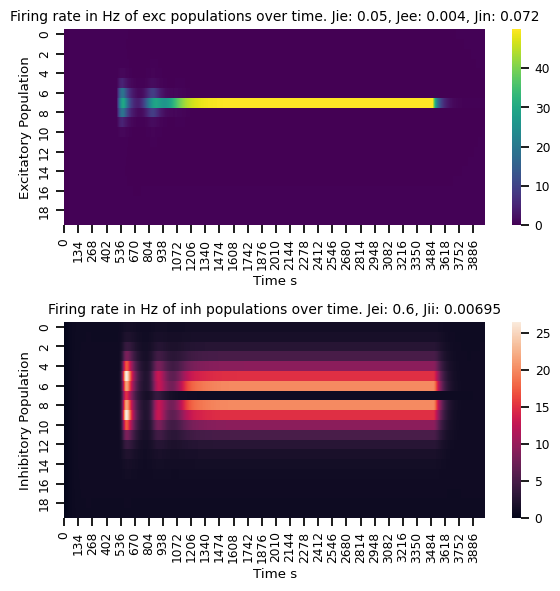

In [ ]:
#other instance of stim
def get_In_stim(frequency):
  stim2 = Stim(param,simu, f=[frequency], dur=.3, ISI=.05) #dur = 1s Isi=1s
  In2, range_sim, w, sigmaIn =stim2.sensoryInput(param, simu, sigmaIn = 2.)
  In2 = stim2.In
  sti2 = torch.tensor(In2).float()
  return sti2
#mymodel.forward(stim = sti2)

#get a stimuli sequence for a stim of "8"
sti2 = get_In_stim(8)


# Set the model to evaluation mode
mymodel.eval()

# Forward pass on validation or test data
with torch.no_grad():
    # Assuming `input_data` is your validation or test input
    output = mymodel(stim = sti2) #r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt


HeatMap(output[0], output[1], J)